In [1]:
from importlib import reload
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import r2_score
from aFunctions import *
init_notebook_mode(connected=True)
sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(10,10)})
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

In [2]:
for i in ['aCrossSection', 'rCrossSection']:
    featimp = 'plots/FeatureImportance/'+i
    if not os.path.exists(featimp):
        print(i)
        os.makedirs(featimp)

# Read Data

- In prior EDA notebook we created features, and wrote our data to CSV files
- In this notebook we will model our data, and decide which features provide the most value


In [28]:
mdatar = pd.read_csv('data/mdata.csv', index_col = 0).sort_values(by=['period', 'ticker'])
mdatar = mdatar[mdatar['ticker'] != 'TLT']
mdatar.index = pd.to_datetime(mdatar.index)
mdatar['period.1'] = pd.to_datetime(mdatar['period.1'])
tick = 'rCrossSection'
retwindow = 'RelrtnFv063'
mdatar = mdatar.dropna()
mdatar.shape

(32013, 72)

In [7]:
with open('data/fnamesR.txt', 'r') as f:
    rFeatures = [line.rstrip('\n') for line in f]

In [4]:
mdatar.columns

Index(['clHv010', 'clHv021', 'clHv063', 'clHv126', 'clHv252', 'clRtnH010',
       'clRtnH021', 'clRtnH063', 'clRtnH126', 'clRtnH252', 'relHv010',
       'relHv021', 'relHv063', 'relHv126', 'relHv252', 'relRtnH010',
       'relRtnH021', 'relRtnH063', 'relRtnH126', 'relRtnH252',
       'TrendMASlope10', 'TrendMASlope50', 'TrendMASlope100',
       'TrendMASlope200', 'MeanRevRSI14d', 'TrendRSIs14d', 'MeanRevRSI63d',
       'TrendRSIs63d', 'TrendhBma', 'TrendlBma', 'TrendabsBma', 'aroon_up',
       'aroon_down', 'aroon_diff', 'MACD_12_26', 'MACD_diff', 'MACD_sign',
       'MACD_36_78', 'MACD_sign3x', 'MeanRevFF', 'MeanRevFFEWMA1',
       'MeanRevFFEWMA2', 'MeanRevFFDiff', 'st6mRealized', 'Ret12m1m',
       'Ret12m6m', 'Ret6m1m', 'Ret6m2w', 'Ret3m2w', 'st6mRealized-Rel',
       'Ret12m1m-Rel', 'Ret12m6m-Rel', 'Ret6m1m-Rel', 'Ret6m2w-Rel',
       'Ret3m2w-Rel', 'FIst6mRealized', 'FIRet12m1m', 'FIRet3m2w', 'FIFF',
       'FIRSI14d', 'FIRSIs14d', 'FIRSI63d', 'FIRSIs63d', 'ticker', 'period.1',
 

In [6]:
mdatar.columns[mdatar.columns.isin(rFeatures) == False]

Index(['ticker', 'period.1', 'forwardmmS', 'forwardstdS', 'relRtnF063',
       'SiderelRtnF063', 'relRtn', 'clRtn'],
      dtype='object')

In [30]:
bTestRetWindow = 'relRtnF063'
Y_r = mdatar[[bTestRetWindow, 'ticker']]
Y_r[bTestRetWindow] = np.exp(mdatar[bTestRetWindow]) - 1
Y_r = Y_r.reset_index()
Sharpe_S = Y_r.pivot(index='period', columns='ticker').describe()[bTestRetWindow]
Sharpe_S['CrossSection'] = Y_r.describe()
Sharpe_S.loc['AnnRet'] = ((Sharpe_S.loc['mean']+1)**(252/int(bTestRetWindow[-3:]))-1)
Sharpe_S.loc['AnnVol'] = (Sharpe_S.loc['std']*np.sqrt(252/int(bTestRetWindow[-3:])))
Sharpe_S.loc['AnnSharpe'] = Sharpe_S.loc['AnnRet']/Sharpe_S.loc['AnnVol']
(Sharpe_S*100).round(2)

ticker,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY,CrossSection
count,355700.00,355700.00,355700.00,355700.00,355700.00,355700.00,355700.00,355700.00,355700.00,3201300.00
mean,-0.08,-0.98,-1.09,0.16,0.76,0.44,0.23,0.38,0.58,0.04
std,4.64,7.06,6.75,3.20,3.43,5.03,6.70,4.83,3.37,5.24
min,-19.75,-28.86,-38.72,-12.91,-10.47,-12.76,-17.75,-17.34,-10.63,-38.72
25%,-2.51,-5.45,-3.82,-1.62,-1.18,-3.01,-4.47,-2.44,-1.59,-2.73
50%,-0.22,-1.11,-0.74,0.23,0.78,-0.25,-0.31,0.38,0.69,0.05
75%,2.51,3.59,2.00,2.27,2.72,3.24,4.46,3.14,2.75,2.81
max,18.83,25.36,45.79,12.32,15.56,31.58,25.40,21.37,14.49,45.79
AnnRet,-0.33,-3.88,-4.31,0.62,3.08,1.76,0.94,1.54,2.36,0.18
AnnVol,9.28,14.11,13.50,6.40,6.85,10.05,13.40,9.66,6.73,10.48


# Relative Returns

- Based on our process for Absolute Returns we will mimic our modeling of Relative to SPY returns 
- We will train a large model as before and reduce features using our importance measures
- Once our side model is trained, we can use shap package as before to understand model forecasts
- Sizing model can also be trained, and additional features used for size model
- An additional thing we did here, was to unscale our data, & compare scaled/unscaled top 20% importance sets
- Where

In [31]:
retwindow = 'relRtnF063'
train_end = '2017-9-30'
test_start = '2017-12-31'

X = mdatar[rFeatures]
Y = mdatar['Side'+retwindow]
t1 = pd.Series(Y.index, index=Y.index, name = 't1')

X_train = X.loc[mdatar.index < train_end]
X_test = X.loc[mdatar.index > test_start]
Y_train = Y.loc[mdatar.index < train_end]
Y_test = Y.loc[mdatar.index > test_start]
wa = (mdatar['forwardmmS'] - .5).abs()
wts = wa*1/(wa.sum())
wts = getTimeDecay(wts,clfLastW=.25)
print('RELATIVE RETURNS')
print('Dropped Records', mdatar.shape[0] - Y_train.shape[0] - Y_test.shape[0])
print('X Shape', X.shape)
print(X.index.min())

RELATIVE RETURNS
Dropped Records 567
X Shape (32013, 64)
2005-06-30 00:00:00


In [33]:
sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(8,8)})
sns.set_context("notebook", font_scale=.85, rc={"lines.linewidth": 2.})
sim = 1

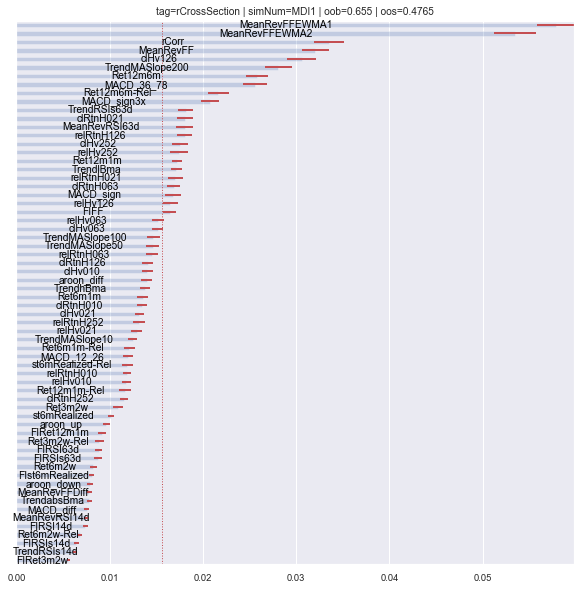

In [ ]:
clf = RandomForestClassifier(n_estimators=1,
                             criterion = 'gini', bootstrap=False, class_weight='balanced',
                             max_depth=5, max_features=2, min_samples_split=.02)
bc=BaggingClassifier(base_estimator=clf, n_estimators=200,max_samples=.5,max_features=1.0)
bc.fit(X_train,Y_train, sample_weight=wts.loc[wts.index < train_end])


OOB, OOS = bc.score(X_train,Y_train), bc.score(X_test,Y_test)
MDI = featImpMDI(bc, X_train.columns)  
plotFeatImportances('plots/FeatureImportance/'+tick+'/', 
                    MDI, OOB, OOS, 'MDI', tag=tick, simNum='MDI'+str(sim))

MDA, OOS, OOB = featImpMDA(bc, X=X, y=Y, cv=4, 
                           sample_weight = wts, t1 = t1,  pctEmbargo = .01, scoring='accuracy')

plotFeatImportances('plots/FeatureImportance/'+tick+'/', 
                    MDA,  OOB,  OOS,  'MDA', tag=tick,  simNum='MDA'+str(sim))

sim += 1

In [ ]:
print('Calculating SFI ....')
clf = RandomForestClassifier(n_estimators=1,
                             criterion = 'gini', bootstrap=False, class_weight='balanced',
                             max_depth=5, max_features=1, min_samples_split=.02)
bc=BaggingClassifier(base_estimator=clf, n_estimators=200,max_samples=.5,max_features=1.0)
bc.fit(X_train,Y_train, sample_weight=wts.loc[wts.index < train_end])
SFI = ImpSFI(featNames = X.columns.values, clf = bc, trnsX=X,  Y=Y, wts = wts,  
             scoring = 'accuracy', t1 = t1)
plotFeatImportances('plots/FeatureImportance/'+tick+'/',
                    SFI,  OOB,  SFI['mean'].mean(), 'SFI',  tag=tick,  simNum='SFI'+str(sim))

In [ ]:
MDI_Feats = list(MDI[MDI['mean']> MDI['mean'].quantile(.80)].sort_values(by=['mean'], ascending=False).index)
SFI_Feats = list(SFI[SFI['mean']> SFI['mean'].quantile(.80)].index)
MDA_Feats = list(MDA[MDA['mean']> MDA['mean'].quantile(.80)].sort_values(by=['mean'], ascending=False).index)
selFeats = np.concatenate((MDI_Feats, MDA_Feats, SFI_Feats))
selFeats = sorted(list(set(selFeats)))
print(len(selFeats))
selFeats

# Feature Selection

- Below we use a blend of top MDI, SFI, & MDA features
- This is paired down from a starting set of roughly ~ 90 Features, Using our MDI/MDA/SFI on all features, we start with the top 20% of features for each, see above
- We take the top 20% set of features as a starting point to re-run MDI / MDA importances
- We also tune our model by altering: class wts, tree depth, min sample split, # of trees, max samples per tree
- Each of these can be used to help reduce model overfitting & improve cross validated performance


In [ ]:
bcparam = dict(classwtd = 'balanced', 
               mdepth = 5, 
               mfeats = 1,
               minssplit = .02,
               nest= 400, 
               maxsample=.7)

sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(8,8)})
sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.})

selFeats = ['FIst6mRealized', 
     'TrendMASlope100', 'TrendMASlope200',
     'aroon_diff', 
     'MeanRevFFDiff', 'MeanRevRSI63d',
     'RelRet3m2w', 'RelRet6m1m',
     'RelccHv063'] 
len(selFeats)

In [ ]:
train_end = '2017-03-31' #'2017-03-31'
test_start = '2017-06-30' #'2017-06-30'
retwindow = 'RelrtnFv063'

X = mdatar[selFeats]
Y = mdatar['Side'+retwindow]

X_train = X.loc[Y.index < train_end]
X_test = X.loc[Y.index > test_start]
Y_train = Y.loc[Y.index < train_end]
Y_test = Y.loc[Y.index > test_start]

wa = mdatar['forwardstdS'].abs()
wts = wa*1/(wa.sum())
wts = getTimeDecay(wts,clfLastW=.25)

print('ABSOLUTE RETURNS')
print('Dropped Records', mdatar.shape[0] - Y_train.shape[0] - Y_test.shape[0])
print('TEST Data: ',Y_test.shape[0], '| Train Data: ',Y_train.shape[0])

clf = RandomForestClassifier(n_estimators=1,
                             criterion = 'entropy', # gini entropy
                             bootstrap=False,
                             class_weight=bcparam['classwtd'],
                             max_depth=bcparam['mdepth'],
                             max_features=bcparam['mfeats'],
                             min_samples_split=bcparam['minssplit'])

bc=BaggingClassifier(base_estimator=clf, 
                     n_estimators=bcparam['nest'],
                     max_samples=bcparam['maxsample'],
                     max_features=1.0)

print(bc)

bc.fit(X_train,Y_train, sample_weight=wts.loc[wts.index < train_end])
pred = bc.predict(X_test)
proba = bc.predict_proba(X_test)
confusion_m = confusion_matrix(Y_test, pred)

print('Train Classification - Bagging')
print(classification_report(Y_train, bc.predict(X_train)))
print('Test Classification - Bagging')
print(classification_report(Y_test, pred))
print('Confusion Matrix - Test Data')
print(confusion_m)

OOB, OOS = bc.score(X_train,Y_train), bc.score(X_test,Y_test)
MDI = featImpMDI(bc, X_train.columns)  
plotFeatImportances('plots/FeatureImportance/'+tick+'/', 
                     MDI, OOB, OOS, 'MDI', tag=tick, simNum='MDI'+str(sim))

MDA, OOS, OOB = featImpMDA(bc, X=X, y=Y, cv=4, 
                           sample_weight = wts, t1 = t1,  pctEmbargo = .02, scoring='accuracy')
plotFeatImportances('plots/FeatureImportance/'+tick+'/', 
                    MDA,  OOB,  OOS,  'MDA', tag=tick,  simNum='MDA'+str(sim))

sim += 1

In [ ]:
X = mdatar[selFeats]
Y = mdatar['Side'+retwindow]

X_train = X.loc[Y.index < train_end]
X_test = X.loc[Y.index > test_start]
Y_train = Y.loc[Y.index < train_end]
Y_test = Y.loc[Y.index > test_start]

lr = LogisticRegression(C=1., solver='lbfgs', class_weight=bcparam['classwtd'])
lr.fit(X_train,Y_train,sample_weight = wts.loc[wts.index < train_end])
predlr = lr.predict(X_test)
confusion_m = confusion_matrix(Y_test, predlr)
print('Train Classification - Logistic Regression')
print(classification_report(Y_train, lr.predict(X_train)))
print('Test Classification - Logistic Regression')
print(classification_report(Y_test, predlr))
print('Confusion Matrix - Test Data')
print(confusion_m) 
print('')

MDA, OOS, OOB = featImpMDA(lr, X=X, y=Y, cv=4, 
                           sample_weight = wts, t1 = t1,  pctEmbargo = .02, scoring='accuracy')
plotFeatImportances('plots/FeatureImportance/'+tick+'/', 
                    MDA,  OOB,  OOS,  'MDA', tag=tick,  simNum='MDA_LR'+str(sim))
sim += 1

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
path = 'plots/FeatureImportance/'+tick+'/'
bcname = bcparam['classwtd'][0:3]+'-'+str(bcparam['maxsample'])+'mrs-'+str(bcparam['mdepth'])+'md-'+str(bcparam['minssplit'])+'mss-'+str(bcparam['nest'])+'t'
print(bcname)
tree_roc_auc1 = roc_auc_score(Y_test, pred)
logit_roc_auc1 = roc_auc_score(Y_test, lr.predict(X_test))
tree_roc_auc = roc_auc_score(Y_test, proba[:,1])
logit_roc_auc = roc_auc_score(Y_test, lr.predict_proba(X_test)[:,1])

fpr_l, tpr_l, thresholds_l = roc_curve(Y_test, lr.predict_proba(X_test)[:,1])
fpr_l1, tpr_l1, _ = roc_curve(Y_test, lr.predict(X_test))
thres_df = pd.Series(list(thresholds_l), name = 'lr').describe().to_frame()

fpr, tpr, thresholds = roc_curve(Y_test, proba[:,1])
fpr1, tpr1, _ = roc_curve(Y_test, pred)
thres_df[bcname] = pd.Series(list(thresholds)).describe()

fpr_t, tpr_t, _ = roc_curve(Y_test, np.full(Y_test.shape,.60))

plt.figure()
plt.plot(fpr, tpr, label='Bagged Classifier*(area = %0.2f)' % tree_roc_auc)
plt.plot(fpr_l, tpr_l, label='Logistic Regression(area = %0.2f)' % logit_roc_auc)
plt.plot(fpr1, tpr1, label='Bagged Classifier*(area = %0.2f)' % tree_roc_auc1)
plt.plot(fpr_l1, tpr_l1, label='Logistic Regression(area = %0.2f)' % logit_roc_auc1)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve Test Set: '+test_start+' to Present')
plt.legend(loc="lower right")
plt.savefig(path+'ROC_'+bcname+'.png')
plt.show()
thres_df

In [ ]:
import xgboost
from sklearn.tree import export_graphviz
from sklearn.datasets import load_iris
from IPython.display import SVG
from graphviz import Source
from IPython.display import display
import shap
shap.initjs()

In [ ]:
bc

In [ ]:
graph = Source(export_graphviz(bc.estimators_[1].estimators_[0], out_file=None, 
                                feature_names = selFeats,
                                class_names = list(Y.unique().astype(str)),
                                rounded = True, proportion = False, 
                                precision = 2, filled = True))
display(SVG(graph.pipe(format='svg')))

In [ ]:
plot_df = pd.DataFrame(lr.predict_proba(X_test), index=Y_test.index, columns=['-1', '+1'])
plot_df['ticker'] = mdatar['ticker'].loc[mdatar.index > test_start]
plot_df['date'] = Y_test.index
plot_df = plot_df[plot_df['ticker'].isin(['SPY', 'QQQ', 'IWM', 'EEM', 'EFA'])] 
sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(8,8)})
sns.set_context("notebook", font_scale=1.15, rc={"lines.linewidth": 2.})
sns.lineplot(x="date", y="+1", hue='ticker', data=plot_df)

In [ ]:
plot_df = pd.DataFrame(bc.predict_proba(X_test), index=Y_test.index, columns=['-1', '+1'])
plot_df['ticker'] = mdatar['ticker'].loc[mdatar.index > test_start]
plot_df['date'] = Y_test.index
plot_df = plot_df[plot_df['ticker'].isin(['SPY', 'QQQ', 'IWM', 'EEM', 'EFA'])] 
sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(8,8)})
sns.set_context("notebook", font_scale=1.15, rc={"lines.linewidth": 2.})
sns.lineplot(x="date", y="+1", hue='ticker', data=plot_df)

# SHAP plots & Feature Interaction / Effect
- Below we fit an XGboost approximation to our above bagged tree model
- This can be used in conjunction with the shap package* to plot shapely additive value plots
- First we plot force plots for 12-2018 & 3-2019, showing feature contribution to forecast for those dates
- Next we show a shap summary plot to show how the range of our values causes our forecast to change
- finally we plot all our interaction plots, to show interaction for each feature across the whole training data set

see https://github.com/slundberg/shap for more details

In [ ]:
params = {
  'silent':1,
  'verbosity':1,
  'colsample_bytree': 1.0,
  'colsample_bylevel': 1/X_train.columns.shape[0],
  'learning_rate': 2,
  'max_depth': 5,
  'num_parallel_tree': 500,
  'objective': 'binary:logistic',
  'subsample': 0.7,
  'tree_method': 'auto',
  'min_child_weight': 20
}
xg = xgboost.train(params, xgboost.DMatrix(X_train, label=np.where(Y_train == -1, 0, 1)), 1)

y_pred = xg.predict(xgboost.DMatrix(X_test))
y_pred = np.where(y_pred<.50,-1,1)
confusion_m = confusion_matrix(Y_test, y_pred)

print('Confusion matrix XGBOOST RF - Test Set' )
print(confusion_m)
print(classification_report(Y_test, y_pred))
print('')

In [ ]:
explainer = shap.TreeExplainer(xg)
shap_values = explainer.shap_values(X)

In [ ]:
_date = '12-28-2017'
d_loc = int([s.strip(',') for s in str(X.index.get_loc(_date)).split()][1])-1
_displ = X.iloc[d_loc].round(2).to_frame()
_displ['SHAP_Val'] = shap_values[d_loc,:]
shap.force_plot(explainer.expected_value, 
                shap_values[d_loc ,:], 
                X.iloc[d_loc].round(2), matplotlib=True)
print(mdatar.iloc[d_loc]['ticker'])
_displ

In [ ]:
_date = '06-28-2018'
d_loc = int([s.strip(',') for s in str(X.index.get_loc(_date)).split()][1])-1
_displ = X.iloc[d_loc].round(2).to_frame()
_displ['SHAP_Val'] = shap_values[d_loc,:]
shap.force_plot(explainer.expected_value, 
                shap_values[d_loc ,:], 
                X.iloc[d_loc].round(2), matplotlib=True)
print(mdatar.iloc[d_loc]['ticker'])
_displ

In [ ]:
_date = '12-31-2018'
d_loc = int([s.strip(',') for s in str(X.index.get_loc(_date)).split()][1])-1
_displ = X.iloc[d_loc].round(2).to_frame()
_displ['SHAP_Val'] = shap_values[d_loc,:]
shap.force_plot(explainer.expected_value, 
                shap_values[d_loc ,:], 
                X.iloc[d_loc].round(2), matplotlib=True)
print(mdatar.iloc[d_loc]['ticker'])
_displ

In [ ]:
_date = '3-29-2019'
d_loc = int([s.strip(',') for s in str(X.index.get_loc(_date)).split()][1])-1
_displ = X.iloc[d_loc].round(2).to_frame()
_displ['SHAP_Val'] = shap_values[d_loc,:]
shap.force_plot(explainer.expected_value, 
                shap_values[d_loc ,:], 
                X.iloc[d_loc].round(2), matplotlib=True)
print(mdatar.iloc[d_loc]['ticker'])
_displ

# Shap Plot Notes
looking at the summary plot, here is a short summary of what the model thinks:
- Higher Momo Indicators, at extremes are actually contrarian indicators.
- IE Slope, RelReturn, Features High = Lower expected Return, & Vice Versa.
- Aroon diff is simply the Aroon Up - Aroon Down indicator simply tracks 50days - Periods since 50 per high. IE high Aroon_diff = strong uptrend in the last ~ 50 days.
- Fractional Diff Features vs it's 20D exponential MA is more of a value measure, where lower values = positive returns, and vice versa
- high TLT 10d realized vs 6m Realized equated to high returns on balance
- 3m Close-Close Realized seemed to center on really low/ high values to indicate negative returns, values in between seem to be negative indicators
- 63d RSI seems to function similar to Fractional differentation

# Dependence Plots
- Nothing especially interesting, except for realized versus momo. IE high realized in the Ticker/SPX performance and Trend Strong = Buy, & at some point this relationship flips
- This also appears to have some outlier values

In [ ]:
shap.summary_plot(shap_values, X)

In [ ]:
print(X.columns)
shap.dependence_plot('FIst6mRealized', shap_values, X)

In [ ]:
shap.dependence_plot('TrendMASlope100', shap_values, X)

In [ ]:
shap.dependence_plot('TrendMASlope200', shap_values, X)

In [ ]:
shap.dependence_plot('aroon_diff', shap_values, X)

In [ ]:
shap.dependence_plot('MeanRevFFDiff', shap_values, X)

In [ ]:
shap.dependence_plot('MeanRevRSI63d', shap_values, X)

In [ ]:
shap.dependence_plot('RelRet3m2w', shap_values, X)

In [ ]:
shap.dependence_plot('RelRet6m1m', shap_values, X)

In [ ]:
shap.dependence_plot('RelccHv063', shap_values, X)

In [ ]:
shap_interaction_values = explainer.shap_interaction_values(X)
shap.summary_plot(shap_interaction_values, X)

In [ ]:
shap.dependence_plot(
    ('TrendMASlope200', "RelccHv063"),
    shap_interaction_values, X,
)

In [ ]:
shap.dependence_plot(
    ('TrendMASlope200', "MeanRevFFDiff"),
    shap_interaction_values, X,
)

In [ ]:
shap.dependence_plot(
    ('RelRet3m2w', "RelRet6m1m"),
    shap_interaction_values, X,
)

# Size Modeling

- Below we model whether or not to take a prediction made by our bagging & logistic side/sign     models 
- We convert our predictions if they are equal to the correct sign to 1, else 0
- To do so we us CV forecast to make sure all y forecasts are out of sample
- Then we can use the same process to model which features help decide to take a +1/-1 sign bet
- Importantly we find that more complex models add much more value on CV f1 scores
- We have four configurations that could be tested for Sign / Size (CV Size F1 Score):
    - Bagging Classifier (BC) & Bagging Classifier () - SIM 
    - Logistic Regression (LR) & Logistic Regression () - SIM 


In [ ]:
bcparam = dict(classwtd = 'balanced', 
               mdepth = 5, 
               mfeats = 2,
               minssplit = .02,
               nest= 400, 
               maxsample=.70)

selFeats = ['FIst6mRealized', 'TrendMASlope100', 'TrendMASlope200', 
            'aroon_diff', 'MeanRevFFDiff', 'MeanRevRSI63d', 
            'RelRet3m2w', 'RelRet6m1m', 'RelccHv063']

clf = RandomForestClassifier(n_estimators=1,
                             criterion = 'entropy', # gini entropy
                             bootstrap=False,
                             class_weight=bcparam['classwtd'],
                             max_depth=bcparam['mdepth'],
                             max_features=bcparam['mfeats'],
                             min_samples_split=bcparam['minssplit'])

bc=BaggingClassifier(base_estimator=clf, 
                     n_estimators=bcparam['nest'],
                     max_samples=bcparam['maxsample'],
                     max_features=1.0)

lr = LogisticRegression(C=1., solver='lbfgs', class_weight=bcparam['classwtd'])

Yh_bc = cvForecast(clf=bc, X=mdatar[selFeats], y=mdatar['Side'+retwindow], 
                sample_weight=wts, t1=t1, cv=5, pctEmbargo=.02)

Yh_lr = cvForecast(clf=lr, X=mdatar[selFeats], y=mdatar['Side'+retwindow], 
                   sample_weight=wts, t1=t1, cv=5, pctEmbargo=.02)

print(bc)

# Bagging Classifier For Side + Size
- We use the same process as above for feature selection, a subset of top features from MDI/MDA/SFI methods
- Sim num 33 is our initial run on all features, .55/.64 OOS f1 (we use f1 for size metric)
- Our final Sim, 57/58 only achieved .65/.64 f1 scores for BC/LR size models
- Also ROC curves appear to be particularly overfit for the bagging classifier

In [ ]:
selFeats_size =  ['FIst6mRealized', 'IVRV3Mhl', 
                  'MeanRevFFEWMA1', 
                  'RelccHv021',  'RelccHv252', 
                  'hlHv063_nN', 'reliv063d_SPY', 'reliv063d_SPY_nN']

bcparam_s = dict(classwtd = 'balanced', #
               mdepth = 4, 
               mfeats = 1,
               minssplit = .05,
               nest= 400, 
               maxsample=.50)

sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(8,8)})
sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.})

Y = mdatar['Side'+retwindow]
Y = pd.Series(np.where(Y == Yh_bc, 1, 0),index = Y.index)
X = mdatar[selFeats_size]

X_train = X.loc[X.index < train_end]
X_test = X.loc[X.index > test_start]
Y_train = Y.loc[X.index < train_end]
Y_test = Y.loc[X.index > test_start]

wa = mdatar['forwardstdS'].abs()
wts = wa*1/(wa.sum())
wts = getTimeDecay(wts,clfLastW=.25)

print('ABSOLUTE RETURNS - SIZE')
print('Dropped Records', mdatar.shape[0] - Y_train.shape[0] - Y_test.shape[0])
print('TEST Data: ',Y_test.shape[0], '| Train Data: ',Y_train.shape[0])

clfs = RandomForestClassifier(n_estimators=1,
                             criterion = 'entropy', # gini entropy
                             bootstrap=False,
                             class_weight=bcparam_s['classwtd'],
                             max_depth=bcparam_s['mdepth'],
                             max_features=bcparam_s['mfeats'],
                             min_samples_split=bcparam_s['minssplit'])

bcs=BaggingClassifier(base_estimator=clfs, 
                     n_estimators=bcparam_s['nest'],
                     max_samples=bcparam_s['maxsample'],
                     max_features=1.0)

bcs.fit(X_train,Y_train, sample_weight=wts.loc[wts.index < train_end])
pred = bcs.predict(X_test)
proba = bcs.predict_proba(X_test)
confusion_m = confusion_matrix(Y_test, pred)

print('Train Classification - Bagging')
print(classification_report(Y_train, bcs.predict(X_train)))
print('Test Classification - Bagging')
print(classification_report(Y_test, pred))
print('Confusion Matrix - Test Data')
print(confusion_m)

OOB, OOS = bcs.score(X_train,Y_train), bcs.score(X_test,Y_test)
MDI = featImpMDI(bcs, X_train.columns)  
plotFeatImportances('plots/FeatureImportance/'+tick+'/', 
                     MDI, OOB, OOS, 'MDI', tag=tick, simNum='MDI_size_bcbc'+str(sim))

MDA, OOS, OOB = featImpMDA(bcs, X=X, y=Y, cv=4, 
                           sample_weight = wts, t1 = t1,  pctEmbargo = .02, scoring='f1')
plotFeatImportances('plots/FeatureImportance/'+tick+'/', 
                    MDA,  OOB,  OOS,  'MDA', tag=tick,  simNum='MDA_size_bcbc'+str(sim))

sim += 1

In [ ]:
print('Calculating SFI ....')
clf = RandomForestClassifier(n_estimators=1,
                             criterion = 'gini', bootstrap=False, class_weight='balanced',
                             max_depth=5, max_features=1, min_samples_split=.02)
bc=BaggingClassifier(base_estimator=clf, n_estimators=200,max_samples=.5,max_features=1.0)
bc.fit(X_train,Y_train, sample_weight=wts.loc[wts.index < train_end])
SFI = ImpSFI(featNames = X.columns.values, clf = bc, trnsX=X,  Y=Y, wts = wts,  
             scoring = 'accuracy', t1 = t1)
plotFeatImportances('plots/FeatureImportance/'+tick+'/',
                    SFI,  OOB,  SFI['mean'].mean(), 'SFI',  tag=tick,  simNum='SFI'+str(sim))

In [ ]:
MDI_Feats = list(MDI[MDI['mean']> MDI['mean'].quantile(.90)].sort_values(by=['mean'], ascending=False).index)
SFI_Feats = list(SFI[SFI['mean']> SFI['mean'].quantile(.90)].index)
MDA_Feats = list(MDA[MDA['mean']> MDA['mean'].quantile(.90)].sort_values(by=['mean'], ascending=False).index)
selFeats_size = np.concatenate((MDI_Feats, MDA_Feats, SFI_Feats))
selFeats_size = sorted(list(set(selFeats_size)))
print(len(selFeats_size))
selFeats_size

In [ ]:
X = mdatar[selFeats_size]
Y = mdatar['Side'+retwindow]
Y = pd.Series(np.where(Y == Yh_bc, 1, 0),index = Y.index)

X_train = X.loc[Y.index < train_end]
X_test = X.loc[Y.index > test_start]
Y_train = Y.loc[Y.index < train_end]
Y_test = Y.loc[Y.index > test_start]

lrs = LogisticRegression(C=1., solver='lbfgs', class_weight=bcparam['classwtd'])
lrs.fit(X_train,Y_train,sample_weight = wts.loc[wts.index < train_end])
predlr = lrs.predict(X_test)
confusion_m = confusion_matrix(Y_test, predlr)
print('Train Classification - Logistic Regression')
print(classification_report(Y_train, lrs.predict(X_train)))
print('Test Classification - Logistic Regression')
print(classification_report(Y_test, predlr))
print('Confusion Matrix - Test Data')
print(confusion_m) 
print('')

MDA, OOS, OOB = featImpMDA(lr, X=X, y=Y, cv=4, 
                           sample_weight = wts, t1 = t1,  pctEmbargo = .02, scoring='f1')
plotFeatImportances('plots/FeatureImportance/'+tick+'/', 
                    MDA,  OOB,  OOS,  'MDA', tag=tick,  simNum='MDA_size_lrlr'+str(sim))
sim += 1

In [ ]:
path = 'plots/FeatureImportance/'+tick+'/'
bcname = bcparam_s['classwtd'][0:3]+'-'+str(bcparam_s['maxsample'])+'mrs-'+str(bcparam_s['mdepth'])+'md-'+str(bcparam_s['minssplit'])+'mss-'+str(bcparam_s['nest'])+'t'
print(bcname)

tree_roc_auc1 = roc_auc_score(Y_test, bcs.predict(X_test))
tree_roc_auc = roc_auc_score(Y_test, np.around(bcs.predict_proba(X_test)[:,1],1))

fpr, tpr, thresholds = roc_curve(Y_test, bcs.predict_proba(X_test)[:,1])
fpr1, tpr1, _ = roc_curve(Y_test, bcs.predict(X_test))
thres_df = pd.Series(list(thresholds), name = bcname).describe().to_frame()

# Logistic Regression ROC 

logit_roc_auc = roc_auc_score(Y_test, lrs.predict_proba(X_test)[:,1])
logit_roc_auc1 = roc_auc_score(Y_test, lrs.predict(X_test))

fpr_l, tpr_l, thresholds_l = roc_curve(Y_test, lrs.predict_proba(X_test)[:,1])
fpr_l1, tpr_l1, _ = roc_curve(Y_test, lrs.predict(X_test))
thres_df['lr'] = pd.Series(list(thresholds_l)).describe()

plt.figure()
plt.plot(fpr, tpr, label='Bagged Classifier*(area = %0.2f)' % tree_roc_auc)
plt.plot(fpr_l, tpr_l, label='Logistic Regression(area = %0.2f)' % logit_roc_auc)
plt.plot(fpr1, tpr1, label='Bagged Classifier*(area = %0.2f)' % tree_roc_auc1)
plt.plot(fpr_l1, tpr_l1, label='Logistic Regression(area = %0.2f)' % logit_roc_auc1)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve Test Set - SIZE: '+test_start+' to Present')
plt.legend(loc="lower right")
plt.savefig(path+'ROC_size'+bcname+'.png')
plt.show()
thres_df

# BACKTESTING! 
- finally we will backtest our model using the Combinatorial Cross Validated & Purged backtest (Lopez De Prado 2018)
- Given our lack of success in using sizing models on our last go around, we will only use side models in conjunction with LR
- Each variation will use a Logistic Regression & Bagged Random Forest Model
- Side only will just use Base (LR or RF), +1/-1 forecast only
- tcost will be set on round trip switches, starting at 10BP to go from +1 to -1
- Each ticker will have an even wt allocation to risk with absolute value leverage at 100%
- As a refresher we can post our sharpe expectations below based on passive buy/hold long ticker/spy


In [ ]:
bcparam = dict(classwtd = 'balanced', 
               mdepth = 5, 
               mfeats = 1,
               minssplit = .02,
               nest= 400, 
               maxsample=.7)

clf = RandomForestClassifier(n_estimators=1,
                             criterion = 'entropy', # gini entropy
                             bootstrap=False,
                             class_weight=bcparam['classwtd'],
                             max_depth=bcparam['mdepth'],
                             max_features=bcparam['mfeats'],
                             min_samples_split=bcparam['minssplit'])

bc=BaggingClassifier(base_estimator=clf, 
                     n_estimators=bcparam['nest'],
                     max_samples=bcparam['maxsample'],
                     max_features=1.0)

print('Sign Model')
print(bc)
print('  ')

In [ ]:
lr = LogisticRegression(C=1., solver='lbfgs', class_weight=bcparam['classwtd'])
lrs = LogisticRegression(C=1., solver='lbfgs', class_weight=bcparam['classwtd'])
print('Sign Model')
print(lr)
print('  ')
print('Size Model')
print(lrs)

In [ ]:
selFeatsSign = ['FIst6mRealized', 
     'TrendMASlope100', 'TrendMASlope200',
     'aroon_diff', 
     'MeanRevFFDiff', 'MeanRevRSI63d',
     'RelRet3m2w', 'RelRet6m1m',
     'RelccHv063'] 

selFeats_size =  ['FIst6mRealized', 'IVRV3Mhl', 
                  'MeanRevFFEWMA1', 
                  'RelccHv021',  'RelccHv252', 
                  'hlHv063_nN', 'reliv063d_SPY', 'reliv063d_SPY_nN']

retwindow = 'RelrtnFv063'
bTestRetWindow = 'RelrtnFv063' # rtnFv001 rtnFv063

X = mdatar[selFeatsSign]
X_s = mdatar[selFeats_size]
Y = mdatar['Side'+retwindow]

Y_r = mdatar[[bTestRetWindow, 'ticker']]
Y_r[bTestRetWindow] = np.exp(mdatar[bTestRetWindow]*int(bTestRetWindow[-3:])) - 1
Y_r = Y_r.reset_index()

wa = mdatar['forwardstdS'].abs()
wts = wa*1/(wa.sum())
wts = getTimeDecay(wts,clfLastW=.25)

print('X Size/Sign shape', X_s.shape,X.shape)
print(Y_r.period.min())

In [ ]:
Sharpe_S.round(3)

In [ ]:
reload(aFunctions)
from aFunctions import *
kn = [2, 35]
betSize = 1.0  #.016
tcS = 'I'

trials = mCombPurgedBacktest(mdatar[selFeatsSign], Y, Y_r, wts, bTestRetWindow,
                                   lr, None, X_s,
                                   k_n = kn, purg_i = .02 , t_cost = 5, test_sims = simnum,
                                   leverage = betSize, tcostScore = tcS)
trials['ModelType'] = 'Side-LR'
trial_stats = trial_stats = trials

trials = mCombPurgedBacktest(mdatar[selFeatsSign], Y, Y_r, wts, bTestRetWindow,
                                   lr, lrs, X_s,
                                   k_n = kn, purg_i = .02 , t_cost = 5, test_sims = simnum,
                                   leverage = betSize, tcostScore = tcS)
trials['ModelType'] = 'Side+Size-LR'
trial_stats = trial_stats.append(trials)

trials = mCombPurgedBacktest(mdatar[selFeatsSign], Y, Y_r, wts, bTestRetWindow,
                                   bc, None, X_s,
                                   k_n = kn, purg_i = .02 , t_cost = 5, test_sims = simnum,
                                   leverage = betSize, tcostScore = tcS)
trials['ModelType'] = 'Side-BC'
trial_stats = trial_stats.append(trials)
trial_stats['btest_window '] = bTestRetWindow
simnum += 1

In [ ]:
ModelType = 'Side-LR'

ts = trial_stats[~trial_stats.isnull().any(axis=1)]
ts = ts[ts['TestYears'] == 	.65]
full_SR_OOS = ts[ts['ModelType'] == ModelType]['Sharpe-OOS'].mean()
full_SR_IS = ts[ts['ModelType'] == ModelType]['Sharpe-IS'].mean()
full_prob0 = np.sum(ts[ts['ModelType'] == ModelType]['Sharpe-OOS'] < 0)/ts[ts['ModelType'] == ModelType]['Sharpe-OOS'].shape[0]
ols_m = sm.OLS(ts[ts['ModelType'] == ModelType]['Sharpe-OOS'], 
               sm.add_constant(ts[ts['ModelType'] == ModelType]['Sharpe-IS']))
ols_r = ols_m.fit()
ss_p = np.round(ols_r.params, 2)
ss_adjr2 = np.round(ols_r.rsquared_adj,2)

ax = sns.regplot(x='Sharpe-IS', 
                 y='Sharpe-OOS', 
                 data = ts[ts['ModelType'] == ModelType], 
                 scatter_kws={"s": 100},
                 color = 'forestgreen')

ax.text(.6,-1.2, 
        "AdjR2 "+str(ss_adjr2)+" | IS SR "+str(np.round(full_SR_IS, 2))+" | OOS SR "+str(np.round(full_SR_OOS, 2))+" | Prob of SR OOS < 0 = "+str(np.round(full_prob0, 2)), 
        horizontalalignment='left', 
        size=25,
        weight='semibold',
        color='black')

ax.set_title(" OOS Performance Degradation - "+ModelType, weight='bold', size = 30)

In [ ]:
ModelType = 'Side+Size-LR'

ts = trial_stats[~trial_stats.isnull().any(axis=1)]
ts = ts[ts['TestYears'] == 	.65]
full_SR_OOS = ts[ts['ModelType'] == ModelType]['Sharpe-OOS'].mean()
full_SR_IS = ts[ts['ModelType'] == ModelType]['Sharpe-IS'].mean()
full_prob0 = np.sum(ts[ts['ModelType'] == ModelType]['Sharpe-OOS'] < 0)/ts[ts['ModelType'] == ModelType]['Sharpe-OOS'].shape[0]
ols_m = sm.OLS(ts[ts['ModelType'] == ModelType]['Sharpe-OOS'], 
               sm.add_constant(ts[ts['ModelType'] == ModelType]['Sharpe-IS']))
ols_r = ols_m.fit()
ss_p = np.round(ols_r.params, 2)
ss_adjr2 = np.round(ols_r.rsquared_adj,2)

ax = sns.regplot(x='Sharpe-IS', 
                 y='Sharpe-OOS', 
                 data = ts[ts['ModelType'] == ModelType], 
                 scatter_kws={"s": 100},
                 color = 'tomato')

ax.text(.75,-1.4,  
        "AdjR2 "+str(ss_adjr2)+" | IS SR "+str(np.round(full_SR_IS, 2))+" | OOS SR "+str(np.round(full_SR_OOS, 2))+" | Prob of SR OOS < 0 = "+str(np.round(full_prob0, 2)), 
        horizontalalignment='left', 
        size=25,
        weight='semibold',
        color='black')

ax.set_title(" OOS Performance Degradation - "+ModelType, weight='bold', size = 30)

In [ ]:
ModelType = 'Side-BC'

ts = trial_stats[~trial_stats.isnull().any(axis=1)]
ts = ts[ts['TestYears'] == 	.65]
full_SR_OOS = ts[ts['ModelType'] == ModelType]['Sharpe-OOS'].mean()
full_SR_IS = ts[ts['ModelType'] == ModelType]['Sharpe-IS'].mean()
full_prob0 = np.sum(ts[ts['ModelType'] == ModelType]['Sharpe-OOS'] < 0)/ts[ts['ModelType'] == ModelType]['Sharpe-OOS'].shape[0]
ols_m = sm.OLS(ts[ts['ModelType'] == ModelType]['Sharpe-OOS'], 
               sm.add_constant(ts[ts['ModelType'] == ModelType]['Sharpe-IS']))
ols_r = ols_m.fit()
ss_p = np.round(ols_r.params, 2)
ss_adjr2 = np.round(ols_r.rsquared_adj,2)

ax = sns.regplot(x='Sharpe-IS', 
                 y='Sharpe-OOS', 
                 data = ts[ts['ModelType'] == ModelType], 
                 scatter_kws={"s": 100},
                 color = 'teal')

ax.text(1.1,-1.4, 
        "AdjR2 "+str(ss_adjr2)+" | IS SR "+str(np.round(full_SR_IS, 2))+" | OOS SR "+str(np.round(full_SR_OOS, 2))+" | Prob of SR OOS < 0 = "+str(np.round(full_prob0, 2)), 
        horizontalalignment='left', 
        size=25,
        weight='semibold',
        color='black')

ax.set_title(" OOS Performance Degradation - "+ModelType, weight='bold', size = 30)

In [ ]:
print(trial_stats.columns)
trial_stats.pivot(index='Trialn', columns='ModelType').describe()['Sharpe-OOS']

In [ ]:
trial_stats.pivot(index='Trialn', columns='ModelType').describe()['Ann-Vol-OOS']

In [ ]:
trial_stats.pivot(index='Trialn', columns='ModelType').describe()['Ann-Return-Net-OOS']

# Standard Walk Forward
   - Here we create a standard walk forward, with a warm up period ~ 10 years
   - Fit using data from 2007 - 2014, then fit monthly look forward predictions
   - We can use these predictions to create a simple long only performance
   - IE when we are short a name, just add SPY. 
   - This can also be done with a Long / Short Performance Set, using Leverage

In [ ]:
def wForwardBacktest(X, Y, Y_r, clf, dStart, dtype = 'Monthly', windows = ['rtnFv001', 'SPYrtnFv001']):
    if dtype not in ['Monthly']:
        raise Exception('Walk forward timing method')
    if dtype == 'Monthly':
        wf_dates = Y_r.groupby([Y_r['period.1'].dt.year, 
                                Y_r['period.1'].dt.month]).max()['period.1'] 
        wf_dates = wf_dates[wf_dates > dStart].values
    pred=[]
    for i in np.arange(0,wf_dates.shape[0]-1):
        l1 = X[(X.index > wf_dates[i]) & (X.index <= wf_dates[i+1])].index
        l2 = X[X.index < wf_dates[i]].index
        
        X_test = X[X.index.isin(l1)]
        Y_test = Y[Y.index.isin(l1)]

        X_train = X[X.index.isin(l2)]
        Y_train = Y[Y.index.isin(l2)]
        
        wa = Y_r[Y_r.index.isin(l2)]['forwardstdS'].abs()
        wts = wa*1/(wa.sum())
        wts = getTimeDecay(wts,clfLastW=.25)
        
        clf.fit(X_train, Y_train, sample_weight=wts)
        pred_ = clf.predict(X_test)
        pred += list(pred_)
    
    Y_r = Y_r[Y_r.index > wf_dates[0]]
    Y_r['Predictions'] = pred
    
    Y_r[windows[0]] = np.exp(Y_r[windows[0]]*int(bTestRetWindow[-3:]))
    Y_r[windows[1]] = np.exp(Y_r[windows[1]]*int(bTestRetWindow[-3:]))
    Y_r = Y_r.dropna()
    Y_r = Y_r.pivot(index='period.1', columns='ticker')
    
    _p = Y_r['Predictions'].ewm(span=5).mean()
    _p = pd.DataFrame(np.where(_p > 0, 1 , -1),_p.index,_p.columns)
    _p = _p[_p.index.isin(wf_dates)]
    _p.columns = pd.MultiIndex.from_product([[_p.columns.name], list(_p.columns.values)])
    
    for t in Y_r.columns.levels[1].values:
        ret = []
        for i in np.arange(1,wf_dates.shape[0]-1):
            _ret = Y_r[windows[0]][t]
            _ret = np.prod(_ret[(_ret.index > wf_dates[i]) & (_ret.index <= wf_dates[i+1])])
            ret.append(_ret)
        _p = _p.join(pd.DataFrame(ret, columns=pd.MultiIndex.from_product([[windows[0]], [t]]),
                     index=wf_pred.index))
        ret = []
        for i in np.arange(1,wf_dates.shape[0]-1):
            _ret = Y_r[windows[1]][t]
            _ret = np.prod(_ret[(_ret.index > wf_dates[i]) & (_ret.index <= wf_dates[i+1])])
            ret.append(_ret)

        _p = _p.join(pd.DataFrame(ret, columns=pd.MultiIndex.from_product([[windows[1]], [t]]),
                         index=wf_pred.index))
        
    pAlloc = 1/len(Y_r.columns.levels[1].values)
    sRets = np.sum(np.where(_p['ticker'] == -1, 
                             _p['SPYrtnFv001'],
                             _p['rtnFv001'])*pAlloc, axis=1)
    #Equal Wtd
    #SPY
        
    return _p, sRets

In [ ]:
((wf_sRet-1)*100).round(2)

In [ ]:
np.std(wf_sRet)*np.sqrt(12)

In [ ]:
np.product(wf_sRet)**(12/len(wf_sRet))-1

In [ ]:
mdata = pd.read_csv('mdata.csv', index_col = 0).sort_values(by=['period.1', 'ticker'])
mdata.index = pd.to_datetime(mdata.index)
mdata['period.1'] = pd.to_datetime(mdata['period.1'])
mdata = mdata[mdata.ticker == 'SPY'][['period.1', 'rtnFv001']]
mdata = mdata.rename(columns={"rtnFv001": "SPYrtnFv001"})

X = mdatar[selFeatsSign]
Y = mdatar['Side'+retwindow]
bTestRetWindow = 'rtnFv001'
Y_r = mdatar[[bTestRetWindow, 'ticker', 'forwardstdS', 'period.1']]
Y_r = Y_r.merge(mdata, on=['period.1'], how='left')
Y_r = Y_r.set_index([Y_r['period.1'].rename('period')])
wf_pred, wf_sRet = wForwardBacktest(X, Y, Y_r, lr, '2014-12-28', dtype = 'Monthly', 
                                       windows = ['rtnFv001', 'SPYrtnFv001'])

wf_pred['ticker'].head()

# Recap Plot of Features

In [ ]:
cmap = sns.cubehelix_palette(20, start=15, rot=-1.00, dark = .3, light=.7)
sns.palplot(cmap)

In [ ]:
sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(40,40)})
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
ids = list(mdatar.columns[mdatar.columns.isin(rFeatures) == False])

mmdatar = pd.melt(mdatar[(ids + selFeatsSign)], 
                      id_vars=ids, 
                      value_vars=selFeatsSign)

g = sns.FacetGrid(mmdatar, col="variable", hue="variable",
                  palette=cmap,
                  height = 8, 
                  col_wrap = 3,
                  sharex=False, 
                  sharey=False,
                  margin_titles=True)
g.map(sns.regplot,'value','forwardmmS')

In [ ]:
path = 'Data/Backtest_Results/'
trial_stats.to_csv(path+'full_test_RELATIVE_Final.csv')
wf_pred.to_csv(path+'Walk_Forward_RELATIVE_Final.csv')

In [ ]:
!jupyter nbconvert --to html ModelFit_s2.ipynb